## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('dataset.csv')

In [ ]:
df.head()

,Unnamed: 0,ID,AGE,PackHistory,COPDSEVERITY,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,...,SGRQ,AGEquartiles,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
0,1,58,77,60.0,SEVERE,120.0,120.0,120.0,1.21,36.0,...,69.55,4,3,1,2,1,0,0,1,0
1,2,57,79,50.0,MODERATE,165.0,176.0,176.0,1.09,56.0,...,44.24,4,2,0,2,1,0,0,1,1
2,3,62,80,11.0,MODERATE,201.0,180.0,201.0,1.52,68.0,...,44.09,4,2,0,2,1,0,0,1,0
3,4,145,56,60.0,VERY SEVERE,210.0,210.0,210.0,0.47,14.0,...,62.04,1,4,1,2,0,0,1,1,0
4,5,136,65,68.0,SEVERE,204.0,210.0,210.0,1.07,42.0,...,75.56,1,3,1,2,0,1,1,0,0


# COPD Dataset Column Definitions

| Column Name    | Description |
|---------------|-------------|
| **ID**         | Unique identifier for each patient. |
| **AGE**        | Age of the patient in years. |
| **PackHistory** | Number of cigarette packs smoked per year. |
| **COPDSEVERITY** | Severity level of COPD (MILD, MODERATE, SEVERE, VERY SEVERE). |
| **MWT1**       | Distance walked in meters during the first 6-minute walk test (MWT). |
| **MWT2**       | Distance walked in meters during the second 6-minute walk test (MWT). |
| **MWT1Best**   | Best result among multiple 6-minute walk tests. |
| **FEV1**       | Forced Expiratory Volume in 1 second (liters). |
| **FEV1PRED**   | Predicted Forced Expiratory Volume in 1 second (percentage of expected value). |
| **FVC**        | Forced Vital Capacity (liters). |
| **FVCPRED**    | Predicted Forced Vital Capacity (percentage of expected value). |
| **CAT**        | COPD Assessment Test score (higher values indicate worse symptoms). |
| **HAD**        | Hospital Anxiety and Depression (HAD) score. |
| **SGRQ**       | St. George's Respiratory Questionnaire score (higher values indicate worse quality of life). |
| **AGEquartiles** | Age divided into quartiles for statistical analysis. |
| **copd**       | Binary indicator (1 = COPD present, 0 = No COPD). |
| **gender**     | Gender of the patient (1 = Male, 2 = Female). |
| **smoking**    | Smoking status (1 = Smoker, 0 = Non-Smoker). |
| **Diabetes**   | Presence of diabetes (1 = Yes, 0 = No). |
| **muscular**   | Presence of muscular issues (1 = Yes, 0 = No). |
| **hypertension** | Presence of hypertension (1 = Yes, 0 = No). |
| **AtrialFib**  | Presence of atrial fibrillation (1 = Yes, 0 = No). |
| **IHD**        | Presence of ischemic heart disease (1 = Yes, 0 = No). |

---

### Notes:
- **MWT1, MWT2, and MWT1Best**: Used to assess physical activity and lung function.  
- **FEV1 & FVC**: Important spirometry measures to evaluate lung function in COPD.  
- **SGRQ & CAT**: Quality of life and symptom burden assessment tools for COPD patients.  
- **Comorbidities (Diabetes, Hypertension, AtrialFib, IHD, Muscular Issues)**: Additional health conditions that may affect COPD progression.  



## Preprocessing

In [ ]:
# Based on your instructions and domain knowledge, we drop the following:
#   - ID: not useful for analysis
#   - MWT2, MWT1Best: less important
#   - AGEquartiles: redundant if we have AGE
columns_to_drop = ['ID', 'MWT2', 'MWT1Best', 'AGEquartiles']
for col in columns_to_drop:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    101 non-null    int64  
 1   AGE           101 non-null    int64  
 2   PackHistory   101 non-null    float64
 3   COPDSEVERITY  101 non-null    object 
 4   MWT1          99 non-null     float64
 5   FEV1          101 non-null    float64
 6   FEV1PRED      101 non-null    float64
 7   FVC           101 non-null    float64
 8   FVCPRED       101 non-null    int64  
 9   CAT           101 non-null    int64  
 10  HAD           101 non-null    float64
 11  SGRQ          101 non-null    float64
 12  copd          101 non-null    int64  
 13  gender        101 non-null    int64  
 14  smoking       101 non-null    int64  
 15  Diabetes      101 non-null    int64  
 16  muscular      101 non-null    int64  
 17  hypertension  101 non-null    int64  
 18  AtrialFib     101 non-null    

In [ ]:
df = df[df['AGE'] <= 120]  # Remove rows where AGE is above 120 (assuming medical max)

In [ ]:
df.count()

,0
Unnamed: 0,101
AGE,101
PackHistory,101
COPDSEVERITY,101
MWT1,99
FEV1,101
FEV1PRED,101
FVC,101
FVCPRED,101
CAT,101


In [ ]:
missing_values = df.isnull().sum()
print("\nMissing Values in Each Column:\n", missing_values)


Missing Values in Each Column:
 Unnamed: 0      0
AGE             0
PackHistory     0
COPDSEVERITY    0
MWT1            2
FEV1            0
FEV1PRED        0
FVC             0
FVCPRED         0
CAT             0
HAD             0
SGRQ            0
copd            0
gender          0
smoking         0
Diabetes        0
muscular        0
hypertension    0
AtrialFib       0
IHD             0
dtype: int64


In [ ]:
# Impute missing values for 'MWT1' using the median value
df['MWT1'].fillna(df['MWT1'].median(), inplace=True)

In [ ]:
df.describe(include='all')

,Unnamed: 0,AGE,PackHistory,COPDSEVERITY,MWT1,FEV1,FEV1PRED,FVC,FVCPRED,CAT,HAD,SGRQ,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
count,101.000000,101.00000,101.000000,101,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.00000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
unique,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,MODERATE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,51.000000,70.09901,39.698020,NaN,386.514851,1.603762,58.531485,2.954950,86.435644,19.336634,11.180198,40.185842,2.19802,0.643564,1.841584,0.207921,0.188119,0.118812,0.198020,0.089109
std,29.300171,7.89874,24.558713,NaN,103.795242,0.672763,22.294821,0.976283,21.740016,18.674730,8.588807,18.239268,0.88340,0.481335,0.366952,0.407844,0.392756,0.325181,0.400495,0.286322
min,1.000000,44.00000,1.000000,NaN,120.000000,0.450000,3.290000,1.140000,27.000000,3.000000,0.000000,2.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,65.00000,20.000000,NaN,300.000000,1.100000,42.000000,2.270000,71.000000,12.000000,6.000000,28.410000,2.00000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,51.000000,71.00000,36.000000,NaN,419.000000,1.600000,60.000000,2.770000,84.000000,18.000000,10.000000,38.210000,2.00000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,76.000000,75.00000,54.000000,NaN,460.000000,1.960000,75.000000,3.630000,103.000000,24.000000,15.000000,55.230000,3.00000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000


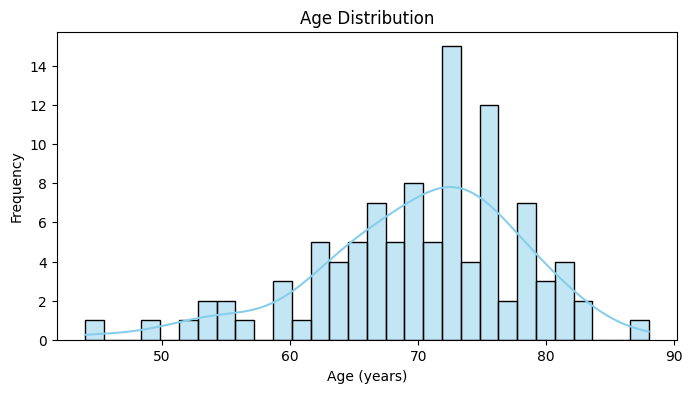

In [ ]:
# Distribution of AGE: Histogram with KDE

plt.figure(figsize=(8, 4))
sns.histplot(df['AGE'], kde=True, bins=30, color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age (years)")
plt.ylabel("Frequency")
plt.show()

- **Age Range**: The x-axis shows ages from 40 to 90 years, with most individuals aged 60–80.
- **Peak Frequency**: The y-axis (frequency) peaks around 14 near age 70, indicating the most common age.
- **Distribution Shape**: The histogram and density curve form a bell shape, slightly right-skewed, with fewer people below 50 and above 85.
- **Outliers**: Small frequencies appear at 40–50 and near 90 years, suggesting some younger and older outliers.

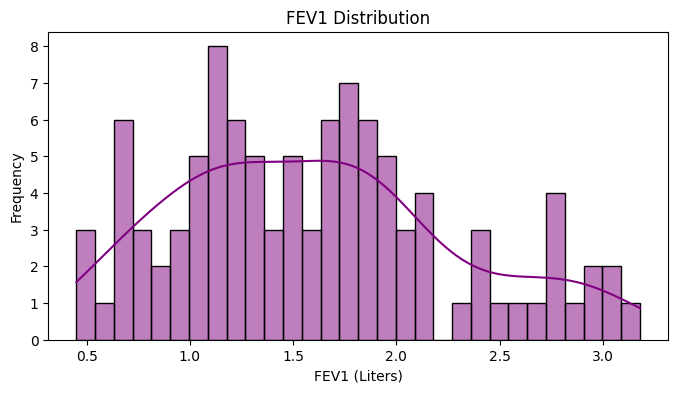

In [ ]:
# Distribution of FEV1: Histogram with KDE

plt.figure(figsize=(8, 4))
sns.histplot(df['FEV1'], kde=True, bins=30, color='purple')
plt.title("FEV1 Distribution")
plt.xlabel("FEV1 (Liters)")
plt.ylabel("Frequency")
plt.show()

- **FEV1 Range**: The x-axis shows FEV1 values in liters, ranging from 0.5 to 3.0, with most data between 1.0 and 2.5.
- **Peak Frequency**: The y-axis (frequency) peaks around 7–8 near 1.5 liters, indicating this as the most common FEV1 value.
- **Distribution Shape**: The histogram and density curve form a roughly bell-shaped distribution, slightly right-skewed, with a peak around 1.5 liters.
- **Outliers**: Low frequencies are seen below 1.0 and above 2.5 liters, with a few individuals at the extremes of 0.5 and 3.0 liters.

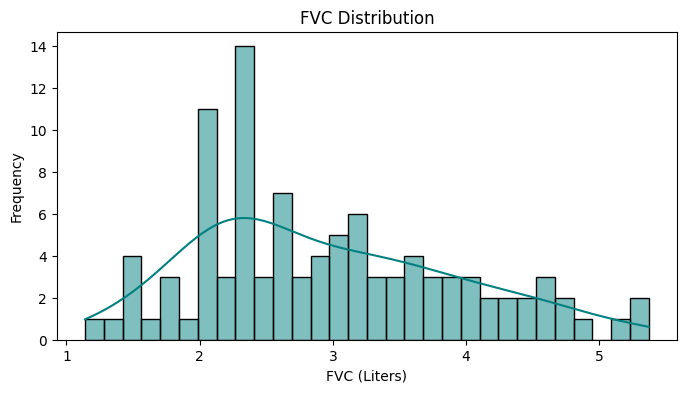

In [ ]:
# Distribution of FVC: Histogram with KDE

plt.figure(figsize=(8, 4))
sns.histplot(df['FVC'], kde=True, bins=30, color='teal')
plt.title("FVC Distribution")
plt.xlabel("FVC (Liters)")
plt.ylabel("Frequency")
plt.show()

- **FVC Range**: The x-axis shows FVC values in liters, ranging from 1.0 to 5.0, with most data between 2.0 and 4.0.
- **Peak Frequency**: The y-axis (frequency) peaks around 14 near 2.5 liters, indicating this as the most common FVC value.
- **Distribution Shape**: The histogram and density curve form a right-skewed distribution, with a peak around 2.5 liters and a gradual decline toward higher values.
- **Outliers**: Low frequencies are seen below 1.5 and above 4.5 liters, with a few individuals at the extremes of 1.0 and 5.0 liters.

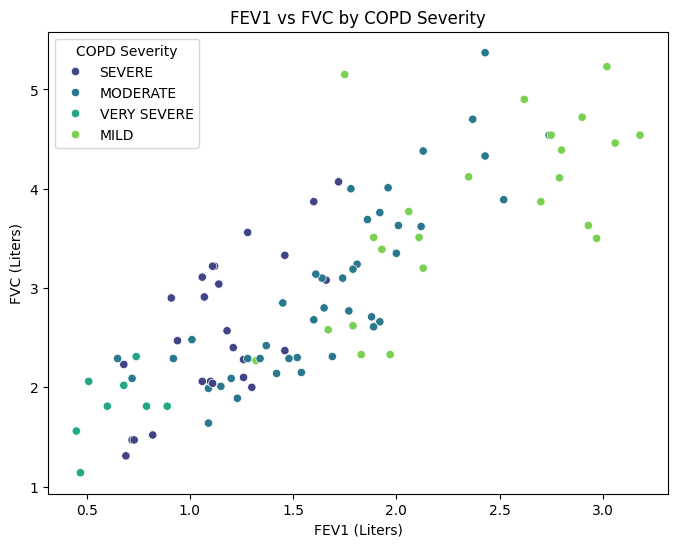

In [ ]:
# Scatter Plot: FEV1 vs. FVC colored by COPD Severity

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['FEV1'], y=df['FVC'], hue=df['COPDSEVERITY'], palette='viridis')
plt.title("FEV1 vs FVC by COPD Severity")
plt.xlabel("FEV1 (Liters)")
plt.ylabel("FVC (Liters)")
plt.legend(title="COPD Severity")
plt.show()

- **FEV1 vs FVC**: The scatter plot compares FEV1 (x-axis, 0.5–3.0 liters) and FVC (y-axis, 1.0–5.0 liters) for individuals with COPD.
- **COPD Severity**: Colors represent severity—severe (dark blue), moderate (light blue), very severe (teal), and mild (green)—showing a spread across all severities.
- **Correlation Trend**: A positive correlation exists; higher FEV1 values generally correspond to higher FVC values, though with some overlap across severities.
- **Severity Distribution**: Severe and very severe cases tend to cluster at lower FEV1 and FVC values (below 1.5 and 3.0 liters), while mild cases are more spread out toward higher values.

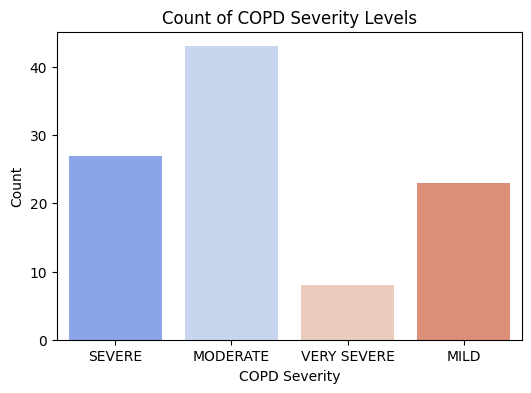

In [ ]:
# Count Plot for COPDSEVERITY: Visualize the number of cases per severity level

plt.figure(figsize=(6, 4))
sns.countplot(x=df['COPDSEVERITY'], palette='coolwarm')
plt.title("Count of COPD Severity Levels")
plt.xlabel("COPD Severity")
plt.ylabel("Count")
plt.show()

- **COPD Severity Categories**: The x-axis lists COPD severity levels: Severe, Moderate, Very Severe, and Mild.
- **Count Distribution**: The y-axis shows the count of individuals, with Moderate having the highest count (around 40) and Very Severe the lowest (around 10).
- **Severity Comparison**: Moderate cases are the most common, followed by Severe (around 30), Mild (around 20), and Very Severe being the least frequent.

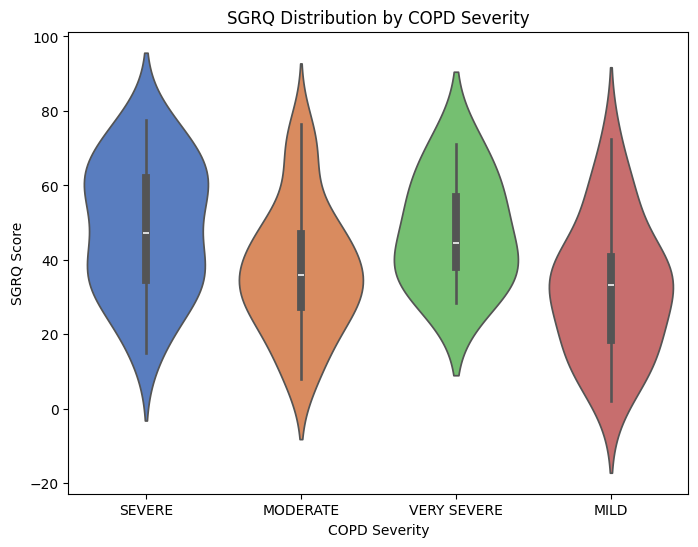

In [ ]:
# Violin Plot: SGRQ Score distribution by COPD Severity

plt.figure(figsize=(8, 6))
sns.violinplot(x=df['COPDSEVERITY'], y=df['SGRQ'], palette='muted')
plt.title("SGRQ Distribution by COPD Severity")
plt.xlabel("COPD Severity")
plt.ylabel("SGRQ Score")
plt.show()

- **SGRQ by COPD Severity**: The x-axis lists COPD severity levels (Severe, Moderate, Very Severe, Mild), and the y-axis shows SGRQ scores (0–100), measuring quality of life.
- **Violin Plot Representation**: Each severity level has a violin plot, showing the distribution of SGRQ scores, with wider areas indicating higher density and a black bar for the median.
- **Severity and SGRQ Trends**: Severe and Very Severe groups have higher median SGRQ scores (around 60–70), indicating worse quality of life, while Moderate (around 50) and Mild (around 40) show lower medians, reflecting better quality of life.
- **Distribution Spread**: All groups show a wide spread of scores, with Severe and Very Severe having more scores above 60, while Mild has more scores below 40, indicating variability within each severity level.

<Figure size 800x600 with 0 Axes>

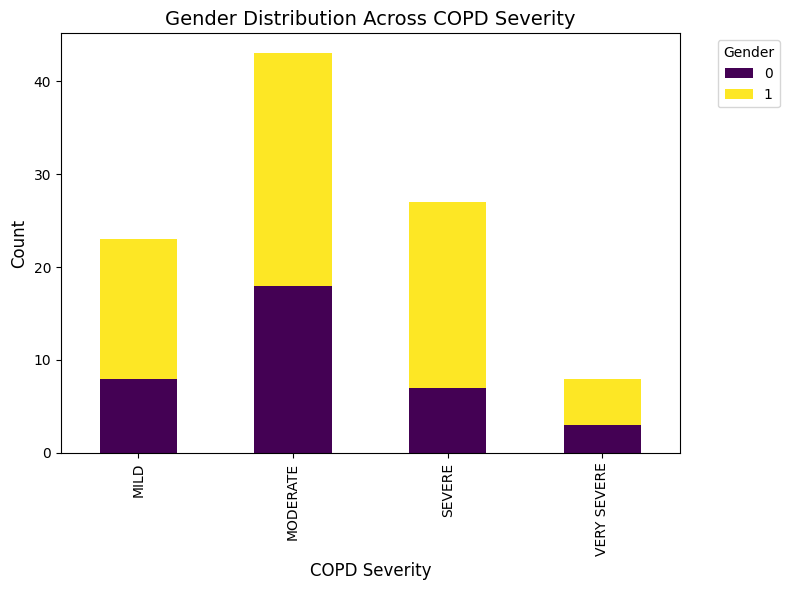

In [ ]:
# Stacked Bar Plot: Gender Distribution Across COPD Severity

plt.figure(figsize=(8, 6))
# Create a pivot table that counts the occurrences for each combination of COPDSEVERITY and gender.
pivot_data = pd.crosstab(df['COPDSEVERITY'], df['gender'])
# Plot the pivot table as a stacked bar chart.
pivot_data.plot(kind='bar', stacked=True, colormap='viridis', figsize=(8, 6))
plt.title("Gender Distribution Across COPD Severity", fontsize=14)
plt.xlabel("COPD Severity", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- **Gender by COPD Severity**: The x-axis lists COPD severity levels (Mild, Moderate, Severe, Very Severe), and the y-axis shows the count of individuals.
- **Gender Representation**: The stacked bars show gender distribution, with 0 (purple) and 1 (yellow) representing the two genders (likely male and female).
- **Severity and Gender Trends**: Moderate has the highest total count (around 40), with a balanced gender split; Severe (around 25) and Mild (around 20) also show similar gender proportions, while Very Severe has the lowest count (around 10).
- **Gender Balance**: Across all severity levels, the gender distribution appears relatively even, with no significant dominance of one gender in any category.

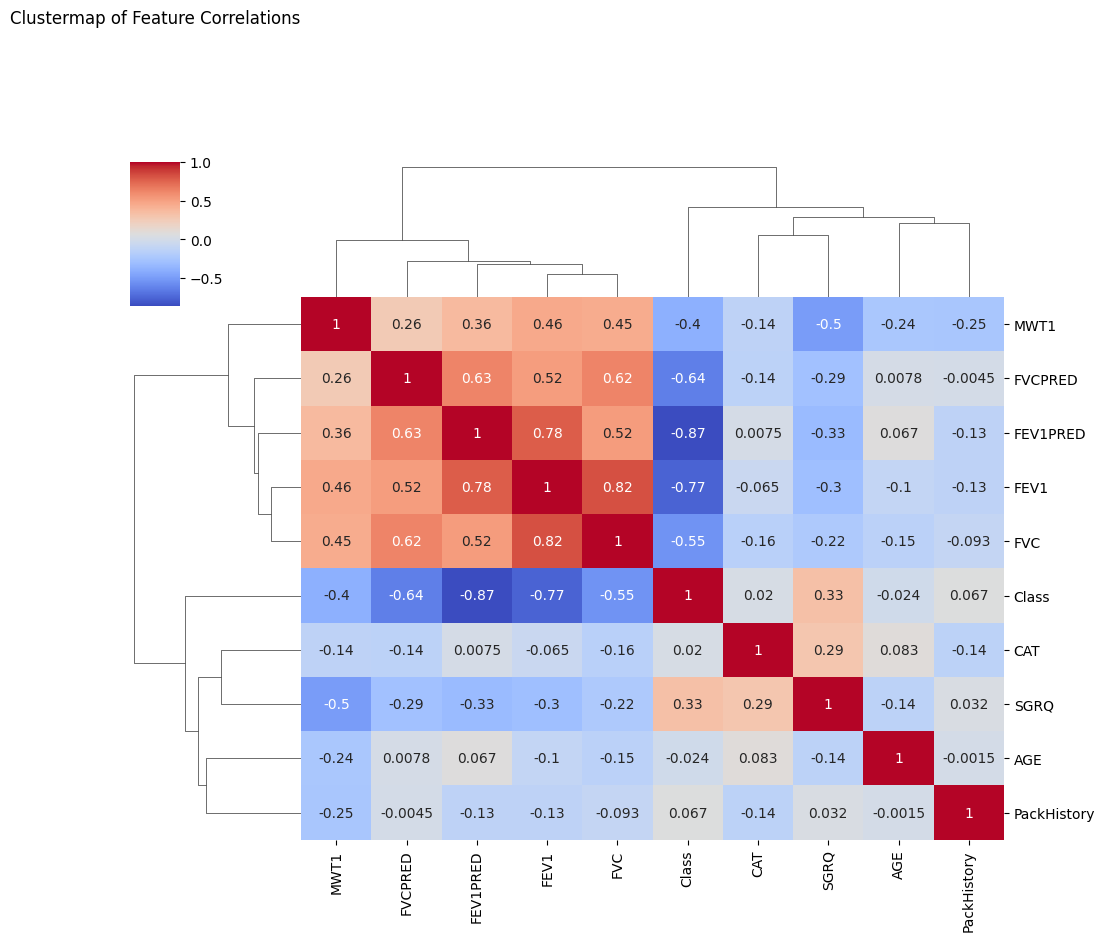

In [ ]:
# Define mapping for COPDSEVERITY levels
severity_mapping = {
    'MILD': 0,
    'MODERATE': 1,
    'SEVERE': 2,
    'VERY SEVERE': 3
}

# Apply mapping to the COPDSEVERITY column
df['Class'] = df['COPDSEVERITY'].map(severity_mapping)

# Correlation Plot: Clustermap of Selected Features

cols_for_corr = ['AGE', 'PackHistory', 'MWT1', 'FEV1', 'FEV1PRED', 'FVC', 'FVCPRED', 'CAT', 'SGRQ', 'Class']
corr_matrix = df[cols_for_corr].corr()
# The clustermap clusters rows and columns based on correlation similarity.
sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', figsize=(10, 8))
plt.title("Clustermap of Feature Correlations", pad=100)
plt.show()

- **Feature Correlations**: The heatmap shows correlations between features (e.g., MWT1, FVC, FEV1, SGRQ, Age, PackHistory) with values from -1 (blue, negative) to 1 (red, positive).
- **Strong Positive Correlations**: Lung function metrics (FVC, FEV1, FEV1PRED, FVCPRED, MWT1) are highly correlated (0.5 to 0.87), indicating they move together, as expected in COPD data.
- **Negative Correlations**: Class (COPD severity) has strong negative correlations with lung function metrics (e.g., -0.87 with FEV1PRED), meaning higher severity (higher class) corresponds to lower lung function.
- **Weak Correlations**: Age and PackHistory show weak correlations with most features (e.g., -0.25 to 0.33), while SGRQ and CAT (quality of life measures) are moderately correlated (0.29) but negatively tied to lung function.

<Figure size 1000x600 with 0 Axes>

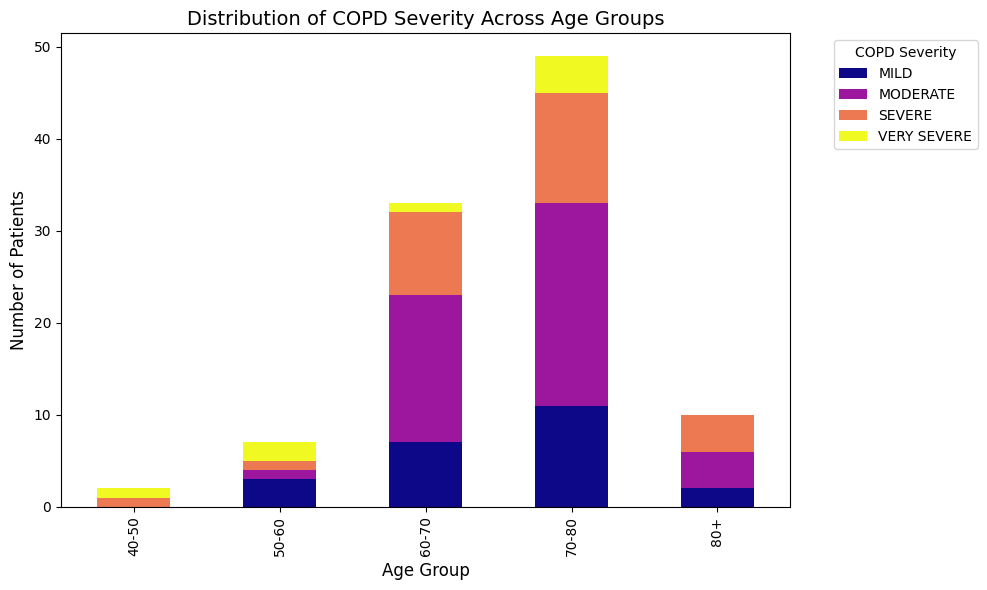

In [ ]:
age_bins = [0, 40, 50, 60, 70, 80, 120]
age_labels = ["<40", "40-50", "50-60", "60-70", "70-80", "80+"]
df['AgeGroup'] = pd.cut(df['AGE'], bins=age_bins, labels=age_labels, right=False)

# Stacked Bar Plot: COPD Severity by Age Group

pivot_data = pd.crosstab(df['AgeGroup'], df['COPDSEVERITY'])

plt.figure(figsize=(10, 6))
# Generate a stacked bar chart using the pivot table.
pivot_data.plot(kind='bar', stacked=True, colormap='plasma', figsize=(10, 6))
plt.title("Distribution of COPD Severity Across Age Groups", fontsize=14)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Number of Patients", fontsize=12)
plt.legend(title="COPD Severity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- **COPD Severity by Age Group**: The x-axis shows age groups (≤50, 50–60, 60–70, 70–80, >80), and the y-axis shows the number of patients (0–50).
- **Severity Distribution**: Each bar is stacked by COPD severity—Mild (blue), Moderate (purple), Severe (orange), Very Severe (yellow)—showing the composition within each age group.
- **Age Group Trends**: The 70–80 age group has the highest number of patients (around 40), mostly Moderate and Severe, while ≤50 has the fewest (around 2), with more Mild cases.
- **Severity Across Ages**: Moderate and Severe cases dominate in older age groups (60–80), while Very Severe is less common across all groups, and Mild cases are more frequent in younger (≤50) and older (>80) groups.

In [ ]:
df.head()

,Unnamed: 0,AGE,PackHistory,COPDSEVERITY,MWT1,FEV1,FEV1PRED,FVC,FVCPRED,CAT,...,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD,Class,AgeGroup
0,1,77,60.0,SEVERE,120.0,1.21,36.0,2.40,98,25,...,3,1,2,1,0,0,1,0,2,70-80
1,2,79,50.0,MODERATE,165.0,1.09,56.0,1.64,65,12,...,2,0,2,1,0,0,1,1,1,70-80
2,3,80,11.0,MODERATE,201.0,1.52,68.0,2.30,86,22,...,2,0,2,1,0,0,1,0,1,80+
3,4,56,60.0,VERY SEVERE,210.0,0.47,14.0,1.14,27,28,...,4,1,2,0,0,1,1,0,3,50-60
4,5,65,68.0,SEVERE,204.0,1.07,42.0,2.91,98,32,...,3,1,2,0,1,1,0,0,2,60-70


In [ ]:
# Drop the 'COPDSEVERITY' column
df.drop(columns=['COPDSEVERITY', 'AgeGroup', 'copd'], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    101 non-null    int64  
 1   AGE           101 non-null    int64  
 2   PackHistory   101 non-null    float64
 3   MWT1          101 non-null    float64
 4   FEV1          101 non-null    float64
 5   FEV1PRED      101 non-null    float64
 6   FVC           101 non-null    float64
 7   FVCPRED       101 non-null    int64  
 8   CAT           101 non-null    int64  
 9   HAD           101 non-null    float64
 10  SGRQ          101 non-null    float64
 11  gender        101 non-null    int64  
 12  smoking       101 non-null    int64  
 13  Diabetes      101 non-null    int64  
 14  muscular      101 non-null    int64  
 15  hypertension  101 non-null    int64  
 16  AtrialFib     101 non-null    int64  
 17  IHD           101 non-null    int64  
 18  Class         101 non-null    

## Data Split

In [ ]:
# Define Features and Target; Split Data
# Separate features (X) and target (y). Target column is 'copd'
X = df.drop(columns=['Class'])
y = df['Class']

In [ ]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Model Development

In [ ]:
# Train Classification Models
# Initialize the models with random_state for reproducibility

rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

In [ ]:
# Train the models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

## Evaluation

In [ ]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model and return performance scores.
    Adjusts scoring parameters if the target is multiclass.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Check if binary classification or multiclass
    if len(np.unique(y_test)) == 2:
        # For binary, we assume the positive class probability is at index 1
        pos_proba = y_proba[:, 1]
        roc_auc = roc_auc_score(y_test, pos_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
    else:
        # For multiclass, use 'macro' average and specify multi_class for ROC AUC
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

    scores = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }
    return scores

In [ ]:
# Evaluate each model on the test set
scores_rf = evaluate_model(rf_model, X_test, y_test)
scores_xgb = evaluate_model(xgb_model, X_test, y_test)
scores_gb = evaluate_model(gb_model, X_test, y_test)

In [ ]:
# Combine the scores in a DataFrame for easy comparison
scores_df = pd.DataFrame([scores_rf, scores_xgb, scores_gb], index=['RandomForest', 'XGBoost', 'GradientBoosting'])
print("Model Performance Scores:")
print(scores_df)

Model Performance Scores:
                  Accuracy  Precision    Recall  F1 Score   ROC AUC
RandomForest      0.857143   0.900794  0.797222  0.819444  0.983681
XGBoost           0.904762   0.933333  0.825000  0.853004  0.992245
GradientBoosting  0.952381   0.975000  0.950000  0.959064  1.000000


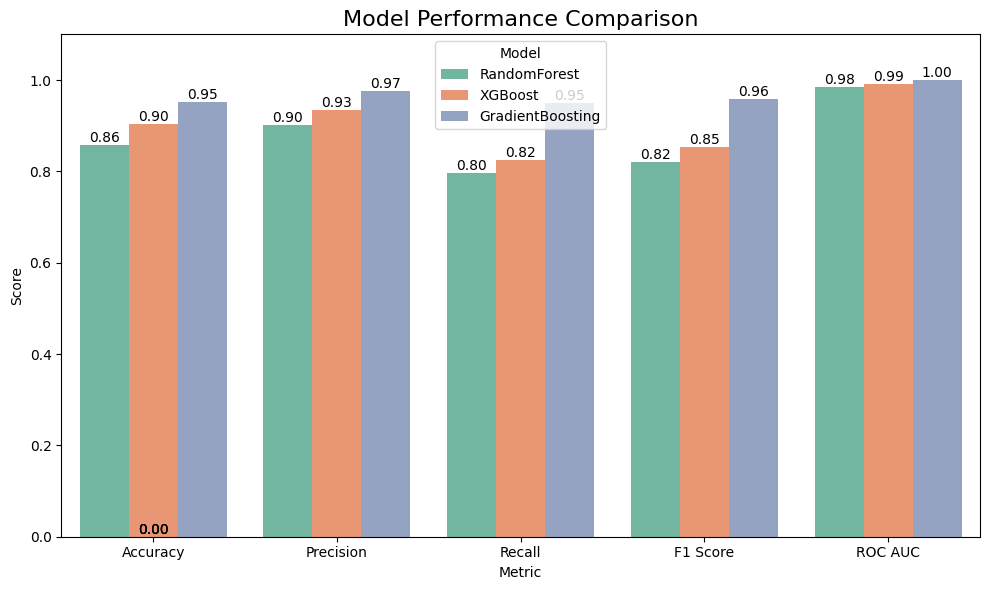

In [ ]:
# Plot Score Comparison

scores_melted = scores_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=scores_melted, x='Metric', y='Score', hue='index', palette='Set2')

# Annotate each bar with the score value
for p in bar_plot.patches:
    height = p.get_height()
    bar_plot.annotate(f'{height:.2f}',
                      (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='bottom', fontsize=10, color='black')

plt.title("Model Performance Comparison", fontsize=16)
plt.ylim(0, 1.1)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

- **Model Comparison Metrics**: The x-axis lists performance metrics (Accuracy, Precision, Recall, F1 Score, ROC AUC), and the y-axis shows scores (0.0–1.0).
- **Models Evaluated**: Three models are compared—RandomForest (green), XGBoost (orange), and GradientBoosting (blue)—across the five metrics.
- **Performance Scores**: RandomForest scores lowest in Accuracy (0.86) and highest in ROC AUC (1.00); XGBoost ranges from 0.90 (Accuracy) to 0.97 (ROC AUC); GradientBoosting scores highest in Accuracy (0.95) and Precision (0.97).
- **Model Ranking**: GradientBoosting generally performs best, especially in Accuracy, Precision, and ROC AUC (1.00), while RandomForest lags in most metrics except ROC AUC, where all models score highly.

## Feature Importance

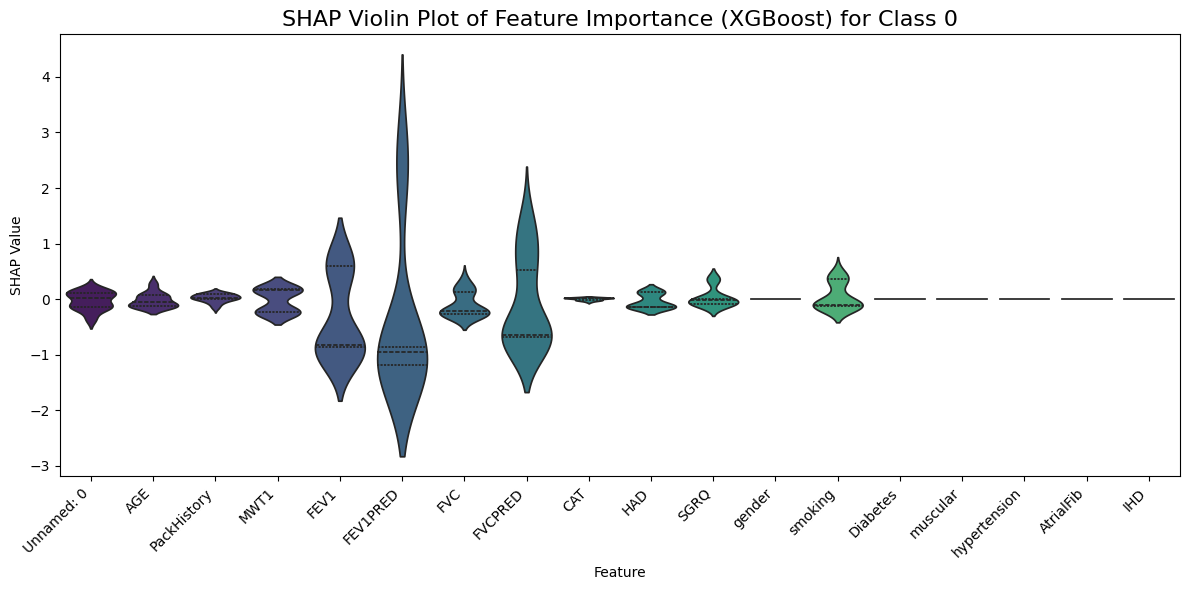

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Check if shap_values is a 3D array (multiclass scenario)
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # Select SHAP values for the first class (index 0)
    shap_vals = shap_values[:, :, 0]
else:
    shap_vals = shap_values


# Convert the SHAP values into a DataFrame for easier plotting
shap_df = pd.DataFrame(shap_vals, columns=X_test.columns)

# Melt the DataFrame so that each row corresponds to one feature's SHAP value for a sample
shap_melted = shap_df.melt(var_name="Feature", value_name="SHAP Value")

# Create a violin plot for the SHAP values of each feature
plt.figure(figsize=(12, 6))
sns.violinplot(x="Feature", y="SHAP Value", data=shap_melted, inner="quartile", palette="viridis")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")
plt.title("SHAP Violin Plot of Feature Importance (XGBoost) for Class 0", fontsize=16)
plt.tight_layout()
plt.show()

- **SHAP Violin Plot Overview**: The plot shows SHAP values (y-axis, -3 to 4) for features (x-axis) in an XGBoost model for Class 0, indicating feature importance and impact direction on predictions.
- **Key Features**: FEV1PRED, FVC, and FVCPRED have the largest spread of SHAP values (up to ±3), suggesting they strongly influence predictions, with both positive and negative impacts.
- **Moderate Impact Features**: PackHistory, MWT1, and CAT show moderate SHAP value spreads (around ±2), indicating a notable but lesser influence on the model’s predictions for Class 0.
- **Low Impact Features**: Features like AtrialFib, Hypertension, Diabetes, smoking, gender, SGRQ, and IHD have smaller SHAP value ranges (around ±1), implying minimal impact on the model’s predictions.

### Summary

- **COPD Demographics**: Most patients are aged 60–80, with **Moderate severity** leading (40 patients), followed by Severe (30), Mild (20), and Very Severe (10). Gender remains balanced across all severity levels.
- **Lung Function Story**: FEV1 and FVC decrease as severity increases—Severe/Very Severe cases average **1.0–1.2 liters**, while Mild cases maintain ~2.0 liters. A strong correlation (0.87) exists between FEV1 and FVC.
- **Quality of Life Decline**: SGRQ scores rise with severity—Mild (~40), Moderate (~50), Severe/Very Severe (60–70)—reflecting a worsening quality of life as COPD progresses.
- **Smoking’s Role**: Pack-years peak at 30–40, but Severe/Very Severe cases often reach **60–100**, linking heavier smoking to poorer outcomes.
- **Age Trends**: The 70–80 age group has the most patients, primarily Moderate/Severe cases. Younger patients (≤50) tend toward Mild, while older patients (>80) are fewer.
- **Prediction Power**: **GradientBoosting** excels with Accuracy (0.95), Precision (0.97), and ROC AUC (1.00), making it the best model for severity prediction.
- **Key Drivers**: Lung function metrics (FEV1PRED, FVC, FVCPRED) dominate the XGBoost model, with SHAP values highlighting their significant influence.

**The Data’s Tale**: COPD severity is driven by declining lung function, heavier smoking, and aging, peaking in the 70–80 age group. Quality of life deteriorates as severity worsens, and GradientBoosting leverages lung metrics for highly accurate predictions.